# Libraries import & setup

In [1]:
!pip install diffusers accelerate transformers safetensors --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.7 MB/s eta 0:00:00


In [2]:
!pip install -U peft --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.1/411.1 kB 8.0 MB/s eta 0:00:00


In [3]:
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler, StableDiffusionImg2ImgPipeline
from huggingface_hub import InferenceClient, hf_hub_download, login
from IPython.display import display
from PIL import Image
import torch
import ast
import re
import os

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
login(token="")

# Step 1: Producing consistent frames via Mistral

In [ ]:
client = InferenceClient(
    provider="hf-inference",
    api_key="",
)

def generate_animation_frames(prompt, steps=5):
    system_message = (
        f"You are an animation assistant to help create ghibli-themed animation frames. "
        f"**Each frame must include the word 'ghibli' or describe the frame as 'ghibli-style'.** "
        f"Break the given ghibli-themed idea into a smooth {steps}-step animation, keeping each frame very simple. "
        f"Do not stray from the given ghibli idea, simple break it into frames that I can use to create a smooth and consistent ghibli animation. "
        f"Each frame must describe only the current ghibli scene, and it must be a simple description. "
        f"Return the result as a **Python list of {steps} strings**, where each string describes a single still frame. "
        f"Do NOT include any titles, explanations, code, formatting, or object coordinates — only a plain list of strings."
        f"Here is an example:\n['A ghibli-themed boy opens a door.', 'He steps into a ghibli glowing forest.', ...]"
    )

    completion = client.chat.completions.create(
        model="mistralai/Mistral-7B-Instruct-v0.3",
        messages=[
            {"role": "system", "content": system_message},
            {"role": "user", "content": prompt}
        ]
    )

    return completion.choices[0].message.content

In [6]:
def normalize_llm_frame_output(raw_output, steps=5):
    # Try parsing as a Python list (only if it starts and ends with brackets)
    if raw_output.strip().startswith("[") and raw_output.strip().endswith("]"):
        try:
            parsed = ast.literal_eval(raw_output)
            if isinstance(parsed, list) and all(isinstance(item, str) for item in parsed):
                return parsed[:steps]
        except Exception:
            pass

    # Fallback 1: Numbered lines like 1. "..."
    pattern = re.compile(r'\d+\s*[\.\)]\s*["“]?(.*?)["”]?(?=\n\d+|\Z)', re.DOTALL)
    matches = pattern.findall(raw_output)

    # Fallback 2: Bullet points or stray quoted lines
    if not matches:
        matches = re.findall(r'["“”\']([^"\n]+)["“”\']', raw_output)

    # Fallback 3: Rough line-by-line fallback if nothing matches
    if not matches:
        matches = [line.strip("-• \n") for line in raw_output.splitlines() if len(line.strip()) > 3]

    # Clean up stray characters
    cleaned = []
    for m in matches[:steps]:
        m = m.replace("‘", "").replace("’", "'").replace("“", "").replace("”", "").strip()
        cleaned.append(m)

    return cleaned

---
# Step 2: text-to-image for first frame

In [ ]:
base_model = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(base_model, safety_checker=None, torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.to("cuda")

In [8]:
lora_repo = "ibrahim7004/ghibli-stableDiff-finetuned"
lora_filename = "v2_pytorch_lora_weights.safetensors"

lora_path = hf_hub_download(repo_id=lora_repo, filename=lora_filename)
pipe.unet.load_attn_procs(lora_path)

v2_pytorch_lora_weights.safetensors:   0%|          | 0.00/3.23M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/diffusers/loaders/unet.py:212: FutureWarning: `load_attn_procs` is deprecated and will be removed in version 0.40.0. Using the `load_attn_procs()` method has been deprecated and will be removed in a future version. Please use `load_lora_adapter()`.
  deprecate("load_attn_procs", "0.40.0", deprecation_message)


In [9]:
def save_img(image, idx, output_dir="/content/frames"):
    os.makedirs(output_dir, exist_ok=True)
    image_path = os.path.join(output_dir, f"frame_{idx}.png")
    image.save(image_path)

    init_image = Image.open(image_path).convert("RGB")
    init_image = init_image.resize((512, 512))
    return init_image

----
# Step 3: img2img for remaining frames

In [10]:
img2img_pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    safety_checker=None,
    torch_dtype=torch.float16
).to("cuda")

img2img_pipe.unet.load_attn_procs(lora_path)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


---

In [21]:
def generate_frames(frames):
    for idx, frame in enumerate(frames):
        if idx == 0:
            image = pipe(frame, num_inference_steps=30).images[0]
            saved_image = save_img(image, idx)
            display(image)
        else:
            refined = img2img_pipe(
                prompt=frame,
                image=saved_image,
                strength=0.6,
                guidance_scale=9.0,
                num_inference_steps=40
            ).images[0]
            display(refined)
            saved_image = save_img(refined, idx)

In [18]:
from IPython.display import Image as IPyImage, display

def create_gif_from_frames(folder_path="/content/frames", output_path="/content/animation.gif", duration=100):

    frames = sorted(
        [Image.open(os.path.join(folder_path, f)) for f in os.listdir(folder_path) if f.endswith(".png")],
        key=lambda x: int(os.path.splitext(os.path.basename(x.filename))[0].split('_')[-1])
    )

    frames[0].save(output_path, format="GIF", save_all=True, append_images=frames[1:], duration=duration, loop=0)
    print(f"GIF saved to {output_path}")

    display(IPyImage(filename=output_path))

# Main

Enter an animation sequence: two ghibli boys play in a ghibli-themed forest
['Two ghibli boys run and play amidst a ghibli-style forest.',
'They arrive at a ghibli forest clearing, surrounded by tall, ancient trees.',
'The boys discover a ghibli-themed ancient stone structure deep in the forest.',
'They climb on the stone structure, peering into a mysterious, glowing cave.',
'The boys, filled with curiosity and wonder, step cautiously into the ghibli-style cave.']
['Two ghibli boys run and play amidst a ghibli-style forest.', 'They arrive at a ghibli forest clearing, surrounded by tall, ancient trees.', 'The boys discover a ghibli-themed ancient stone structure deep in the forest.', 'They climb on the stone structure, peering into a mysterious, glowing cave.', 'The boys, filled with curiosity and wonder, step cautiously into the ghibli-style cave.']


  0%|          | 0/30 [00:00<?, ?it/s]

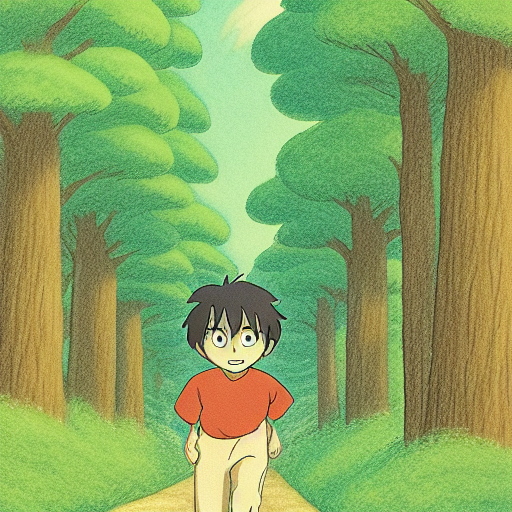

  0%|          | 0/24 [00:00<?, ?it/s]

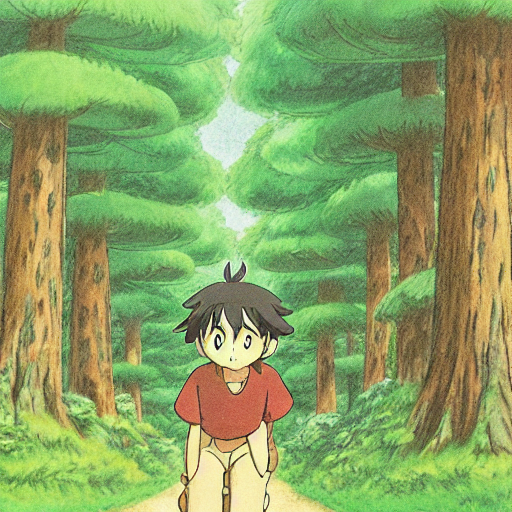

  0%|          | 0/24 [00:00<?, ?it/s]

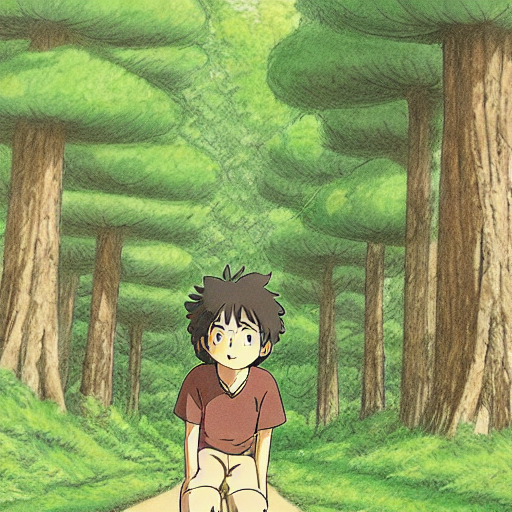

  0%|          | 0/24 [00:00<?, ?it/s]

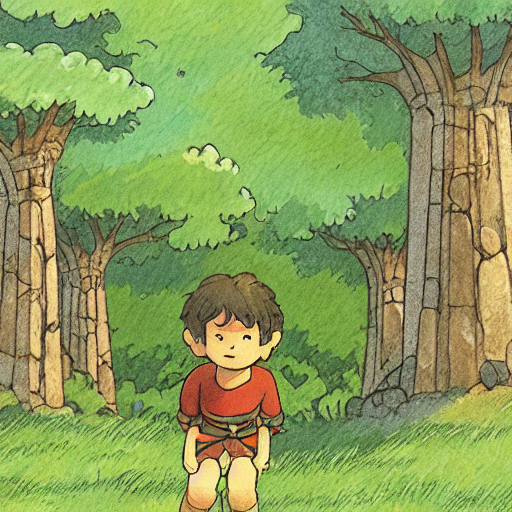

  0%|          | 0/24 [00:00<?, ?it/s]

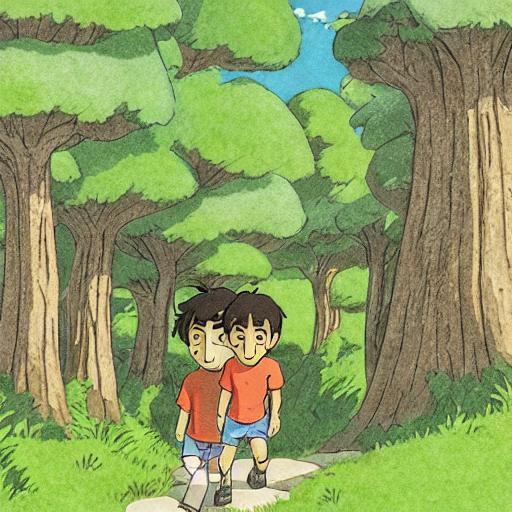

In [24]:
result = generate_animation_frames(input("Enter an animation sequence: "))
print(result)
frames = normalize_llm_frame_output(result, steps=5)
print(frames)
generate_frames(frames)

GIF saved to /content/animation.gif


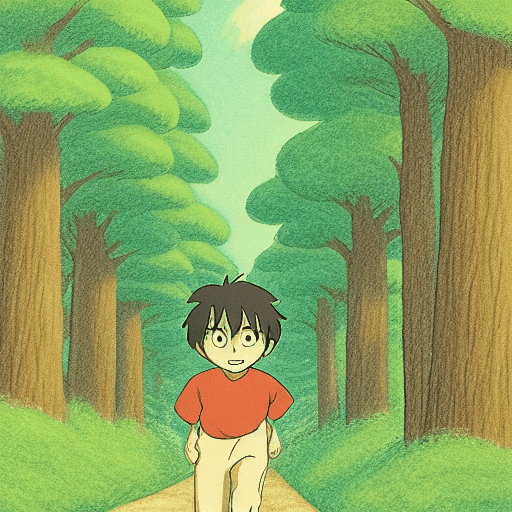

In [25]:
create_gif_from_frames()

---